In [ ]:
# Check if any two groups differ significantly in terms of age, IQ and in-scanner movement 

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import pylab

In [2]:
def load_excel_data(excel_file, spreadsheet, group1, group2, covariate):
    data = pd.read_excel(excel_file, sheet_name=spreadsheet, engine='openpyxl')
    sub_ids = data.iloc[:, 0]
    data.index = sub_ids
    group1_df = data.loc[[ses for ses in group1], covariate]
    group2_df = data.loc[[ses for ses in group2], covariate]
    return group1_df, group2_df

In [3]:
# Check normality of data
def check_norm(data):
    # Visualise data in a histogram
    plt.hist(data
             ,bins = 5
            )
    plt.show()
    
    # Create a quantile-quantile (Q-Q) plot
    sm.qqplot(data, line='q')
    pylab.show()
    
    # Test normality
    t, p = stats.shapiro(data)
    alpha = 0.05 #1e-3

    print('t-statistic = ' + '{0:.10f}'.format(t))
    print('P-value = ' + '{0:.10f}'.format(p))

    # null hypothesis: x comes from a normal distribution
    if p < alpha:
        print("The null hypothesis can be rejected. The sample is NOT normally distributed.")
        return False
    else:
        print("The null hypothesis cannot be rejected. The sample is normally distributed.")
        return True

In [4]:
# Check for equality of variances
def calc_var_equal(d1, norm_d1, d2, norm_d2):
    print("")
    print("Testing equality of variances..")
    alpha = 0.05
    # If normally distributed, perform a Bartlett test
    if norm_d1 == True and norm_d2 == True:
        stat, p = stats.bartlett(d1, d2)
    else:
    # If non-normally distributed, perform a Levene test
        stat, p = stats.levene(d1, d2)

    # null hypothesis: x and y have equal variances
    if p < alpha:
        print("The null hypothesis can be rejected. X and Y do NOT have equal variances.")
        return False
    else:
        print("The null hypothesis cannot be rejected. X and Y have equal variances.")
        return True

In [5]:
# Do a whisker plot
def two_group_whisker_plot(d1, d2):
    # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

    fig, ax = plt.subplots(figsize=(20,8))
    whisker_figure = ax.boxplot([d1, d2], 
                              #notch=True, 
                              #bootstrap=5000, 
                              showfliers=True)
    #ax.set_xticklabels('PUT GROUP NAMES HERE')
    plt.show(whisker_figure)

In [6]:
# Only for continuous variables!!!
def test_sign_diff(d1, norm_d1, d2, norm_d2, var_equal, paired):
    # If normally distributed
    if norm_d1 == True and norm_d2 == True:
        # And with equal variances
        if var_equal == True:
            if paired == True:
                print(stats.ttest_rel(a=d1, b=d2))
            elif paired == False:
                # Do an independent two-sample Student t-test
                print(stats.ttest_ind(a=d1, b=d2, equal_var=True))
            else:
                print("Please enter True or False for the paired argument..")
        # If variances are unequal, perform Welch's test
        else:
            print(stats.ttest_ind(a=d1, b=d2, equal_var=False))
    # If non-normally distributed, conduct a Wilcoxon rank sum (aka Mann-Whitney) test
    else:
        if paired == True:
            print(stats.wilcoxon(d1, d2))
        elif paired == False:
            #https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html
            u, prob = stats.mannwhitneyu(d1, d2)
            print("u = {:g}".format(u))
            print("prob = {:g}".format(prob))
            # to get two-sided p-value:
            two_sided_prob = 2 * prob
            print("P-value = " + str(two_sided_prob))
        else:
            print("Please enter True or False for the paired argument..")

In [7]:
# Check assumptions for the statistical tests and perform the appropriate test
def check_norm_diff(work_dir, excel_file, spreadsheet, group1, group2, covariate, paired):
    # Go into the working directory
    os.chdir(work_dir)
    
    # Load the data and generate two separate data frames, one for each group
    group1_df, group2_df = load_excel_data(excel_file, spreadsheet, group1, group2, covariate)
    
    # Check normality of each group
    print('Normality check for group 1:')
    group1_norm = check_norm(group1_df)
    print('')
    print('Normality check for group 2:')
    group2_norm = check_norm(group2_df)
    
    # Check equality of variances between the two groups
    var_equal = calc_var_equal(group1_df, group1_norm, group2_df, group1_norm)
    print('')
    print('Equality of variances is = ' + str(var_equal))
    
    # Plot group values in a whisker plot
    two_group_whisker_plot(group1_df, group2_df)
    
    # "Pause" the program and ask the user if they agree with the normality checks
    print('')
    while True:
        agree = input('Do you agree with the normality checks? Y/N ')
        if agree == 'Y':
            break
        elif agree == 'N':
            while True:
                print('')
                true_norm = input('Is the distribution of group 1 and 2 normal, respectively? Y/N, Y/N ')
                if true_norm == 'Y, N':
                    group1_norm = True
                    group2_norm = False
                    break
                elif true_norm == 'N, Y':
                    group1_norm = False
                    group2_norm = True
                    break
                elif true_norm == 'N, N':
                    group1_norm = False
                    group2_norm = False
                    break
                else:
                    print('Please type Y/N, Y/N. ')
                        
            break
        
        else:
            print('Please type Y or N. ')
            
    
    # Test whether the difference between the groups is statistically significant
    print('')
    print('Are the differences significant? See below..')
    print('The sample consists of ' + str(len(group1_df)) + ' neurotypical and ' + str(len(group2_df)) + ' autistic individuals.')
    print('Mean and SD of covariate:')
    print('Mean (for NT and ASC) = ' + str(np.mean(group1_df)) + ' and ' + str(np.mean(group2_df)))
    print('SD (for NT and ASC) = ' + str(np.std(group1_df)) + ' and ' + str(np.std(group2_df)))
    test_sign_diff(group1_df, group1_norm, group2_df, group2_norm, var_equal, paired)
    
    print('Done!')
    

In [8]:
# --------------------------------------------------------------------------------------------------------------- #

In [9]:
# # Placebo sessions from the Green+Orange dataset

# Create ID lists
study_name = 'BRCTRADA'
placebo_td = ['001D', '003D', '004D', '007D', '008C', '009B', '010C', '011B', '012C', '013C', '014B', '015D', '016B', '017D', '019B', '020B', '021C', '022C', '023D']
placebo_autism = ['101D', '102C', '103C', '104B', '105B', '106B', '107C', '109C', '110C', '111D', '112B', '113D', '114D', '116B', '117B', '119C', '120C', '123B']

placebo_td_list = [study_name + sub_id[:3] for sub_id in placebo_td]
placebo_autism_list = [study_name + sub_id[:3] for sub_id in placebo_autism]

Normality check for group 1:


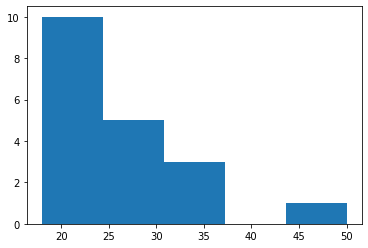

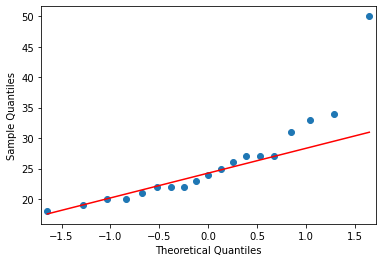

t-statistic = 0.8054091930
P-value = 0.0013709435
The null hypothesis can be rejected. The sample is NOT normally distributed.

Normality check for group 2:


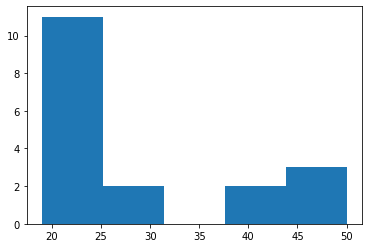

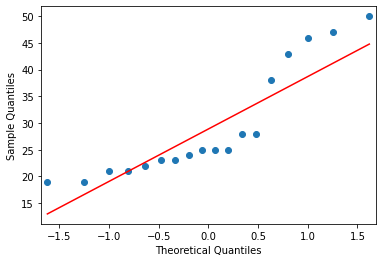

t-statistic = 0.8078395128
P-value = 0.0019642108
The null hypothesis can be rejected. The sample is NOT normally distributed.

Testing equality of variances..
The null hypothesis cannot be rejected. X and Y have equal variances.

Equality of variances is = True


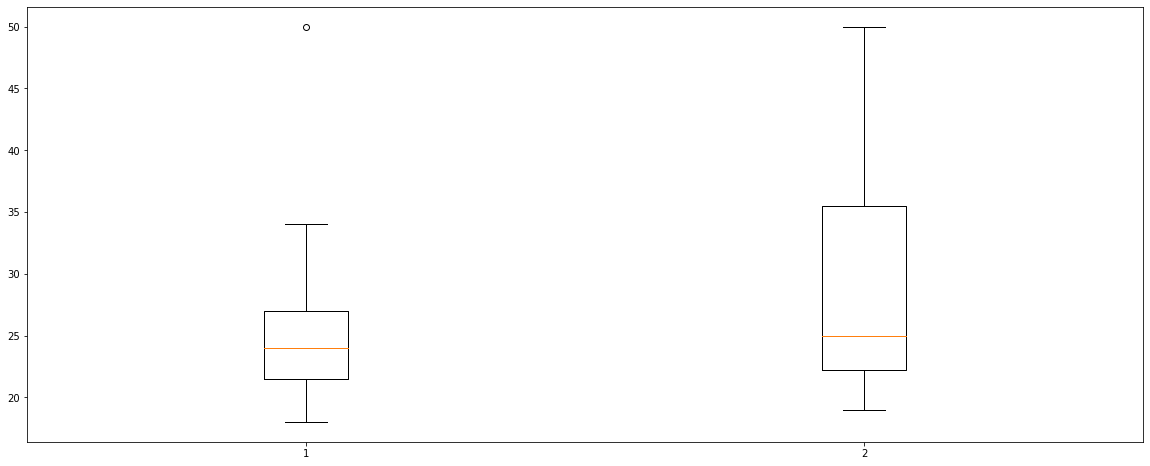


Do you agree with the normality checks? Y/N Y

Are the differences significant? See below..
The sample consists of 19 neurotypical and 18 autistic individuals.
Mean and SD of covariate:
Mean (for NT and ASC) = 25.842105263157894 and 29.27777777777778
SD (for NT and ASC) = 7.213023002252587 and 10.147827110358572
u = 145
prob = 0.218665
P-value = 0.4373308080160584
Done!


In [10]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               placebo_td_list,
               placebo_autism_list,
               'Age',
               paired=False)

Normality check for group 1:


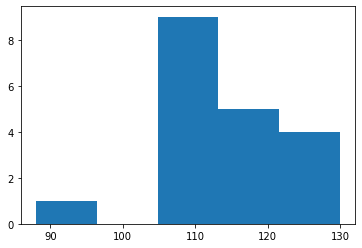

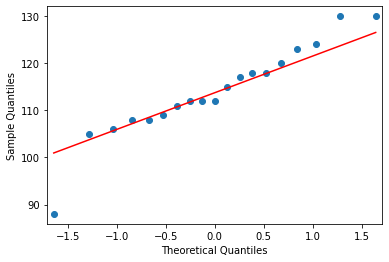

t-statistic = 0.9419453144
P-value = 0.2857666612
The null hypothesis cannot be rejected. The sample is normally distributed.

Normality check for group 2:


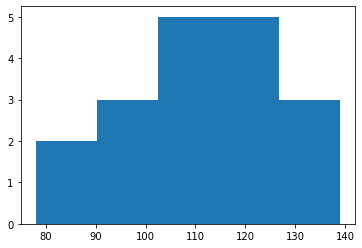

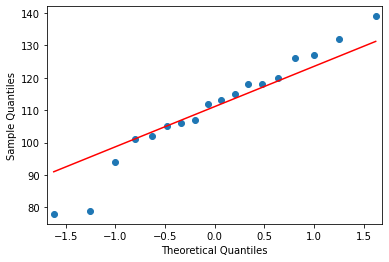

t-statistic = 0.9651502371
P-value = 0.7031416297
The null hypothesis cannot be rejected. The sample is normally distributed.

Testing equality of variances..
The null hypothesis can be rejected. X and Y do NOT have equal variances.

Equality of variances is = False


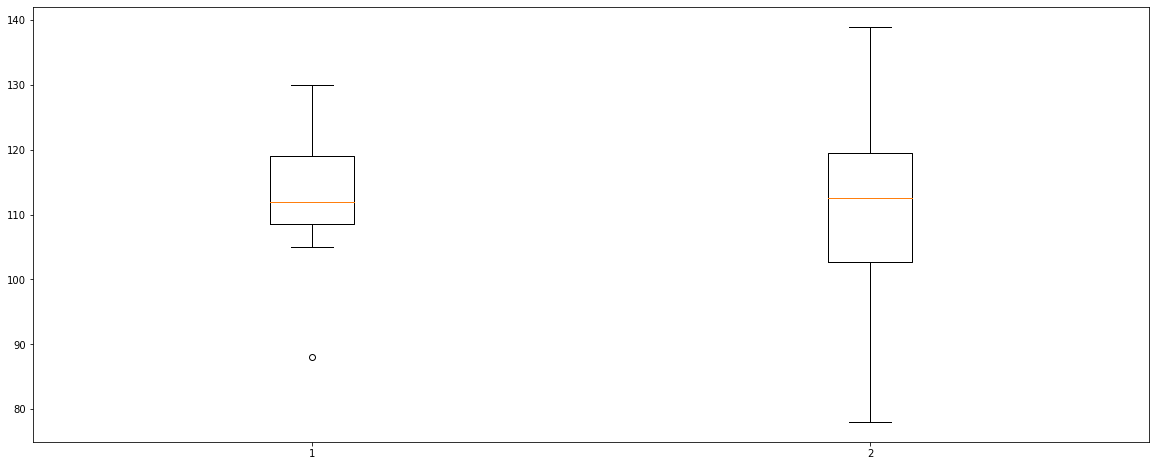


Do you agree with the normality checks? Y/N Y

Are the differences significant? See below..
The sample consists of 19 neurotypical and 18 autistic individuals.
Mean and SD of covariate:
Mean (for NT and ASC) = 114.0 and 110.66666666666667
SD (for NT and ASC) = 9.486832980505138 and 15.923427883328248
Ttest_indResult(statistic=0.7469443277004986, pvalue=0.46145910603710405)
Done!


In [11]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               placebo_td_list,
               placebo_autism_list,
               'IQ', 
                paired=False)

Normality check for group 1:


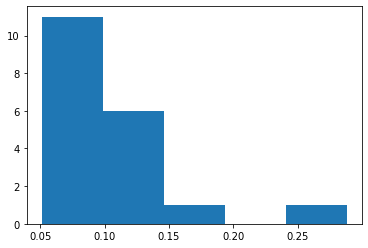

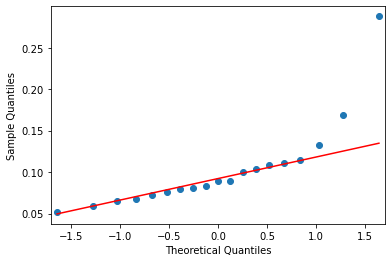

t-statistic = 0.7179619074
P-value = 0.0000917243
The null hypothesis can be rejected. The sample is NOT normally distributed.

Normality check for group 2:


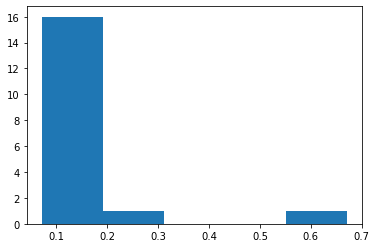

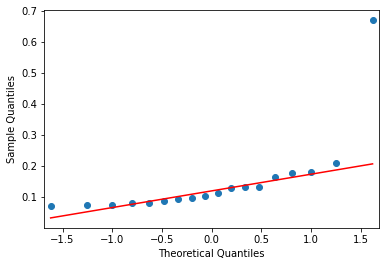

t-statistic = 0.5213336945
P-value = 0.0000012346
The null hypothesis can be rejected. The sample is NOT normally distributed.

Testing equality of variances..
The null hypothesis cannot be rejected. X and Y have equal variances.

Equality of variances is = True


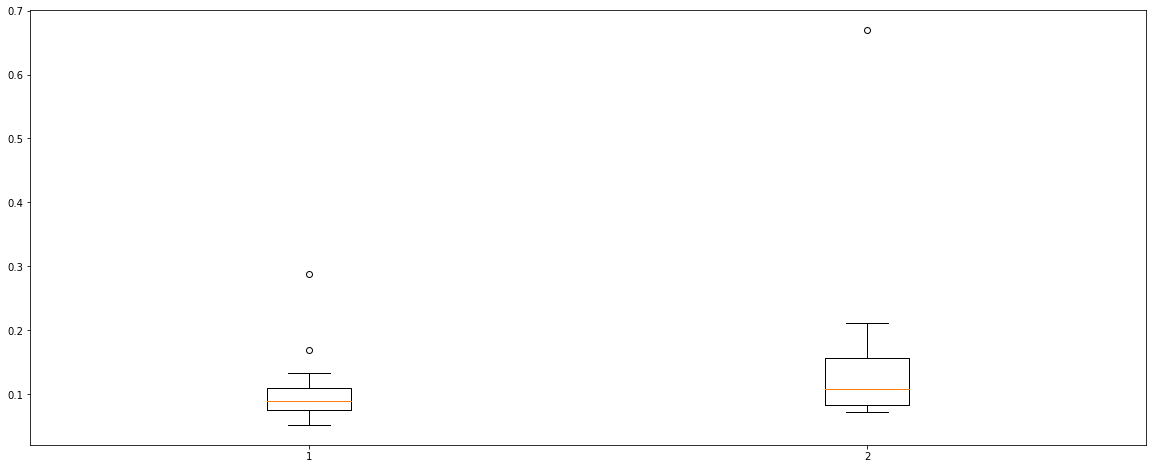

KeyboardInterrupt: Interrupted by user

In [12]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               placebo_td_list,
               placebo_autism_list,
               'mFD',
               paired=False)

In [ ]:
# # Tianeptine sessions from the Green+Orange dataset

# Create ID lists
study_name = 'BRCTRADA'
tianeptine_td = ['001B', '003C', '004C', '007C', '008D', '009C', '010B', '011D', '012B', '013D', '014C', '015B',
              '016D', '017B', '019C', '020C', '021B', '022D', '023B']
tianeptine_autism = ['101C', '102B', '103D', '104D', '105D', '106C', '107D',
          '108B', '109B', '110B', '112C', '113C', '114B', '115D', '116C', '117D', '119D', '120B', '123C']

tianeptine_td_list = [study_name + sub_id[:3] for sub_id in tianeptine_td]
tianeptine_autism_list = [study_name + sub_id[:3] for sub_id in tianeptine_autism]

In [ ]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               tianeptine_td_list,
               tianeptine_autism_list,
               'IQ',
               paired=False)

In [ ]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               tianeptine_td_list,
               tianeptine_autism_list,
               'Age',
               paired=False)

In [ ]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               tianeptine_td_list,
               tianeptine_autism_list,
               'mFD',
               paired=False)

In [ ]:
# Also compare ASC_p vs ASC_T

In [ ]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               placebo_autism_list,
               tianeptine_autism_list,
               'IQ',
               paired=True)

In [ ]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               tianeptine_td_list,
               tianeptine_autism_list,
               'Age',
               paired=True)

In [ ]:
check_norm_diff('/Users/mishodimitrov/Downloads/PhD/Analysis/Tianeptine/Data/Covariates',
               'Covariates.xlsx',
               'data',
               tianeptine_td_list,
               tianeptine_autism_list,
               'mFD',
               paired=True)